Install these if necessary.

In [1]:
# %pip install fastcluster --quiet

Load necessary libraries.

In [2]:
## Basics
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

## ML Packages
from sklearn.cluster import SpectralBiclustering, SpectralCoclustering
from sklearn.feature_selection import VarianceThreshold

## Msc
from PIL import Image

Load dataset.

In [3]:
df = pd.read_csv('00_authors.csv').rename(columns = {'Unnamed: 0': 'Author'}).drop(columns = 'BookID')
X = df.copy().drop(['Author'], axis=1)
authors = df['Author'].values  # n_samples-length array

# Biclustering

## Spectral Biclustering

Let us fit and visualize both the chapters and words using Spectral Biclustering!

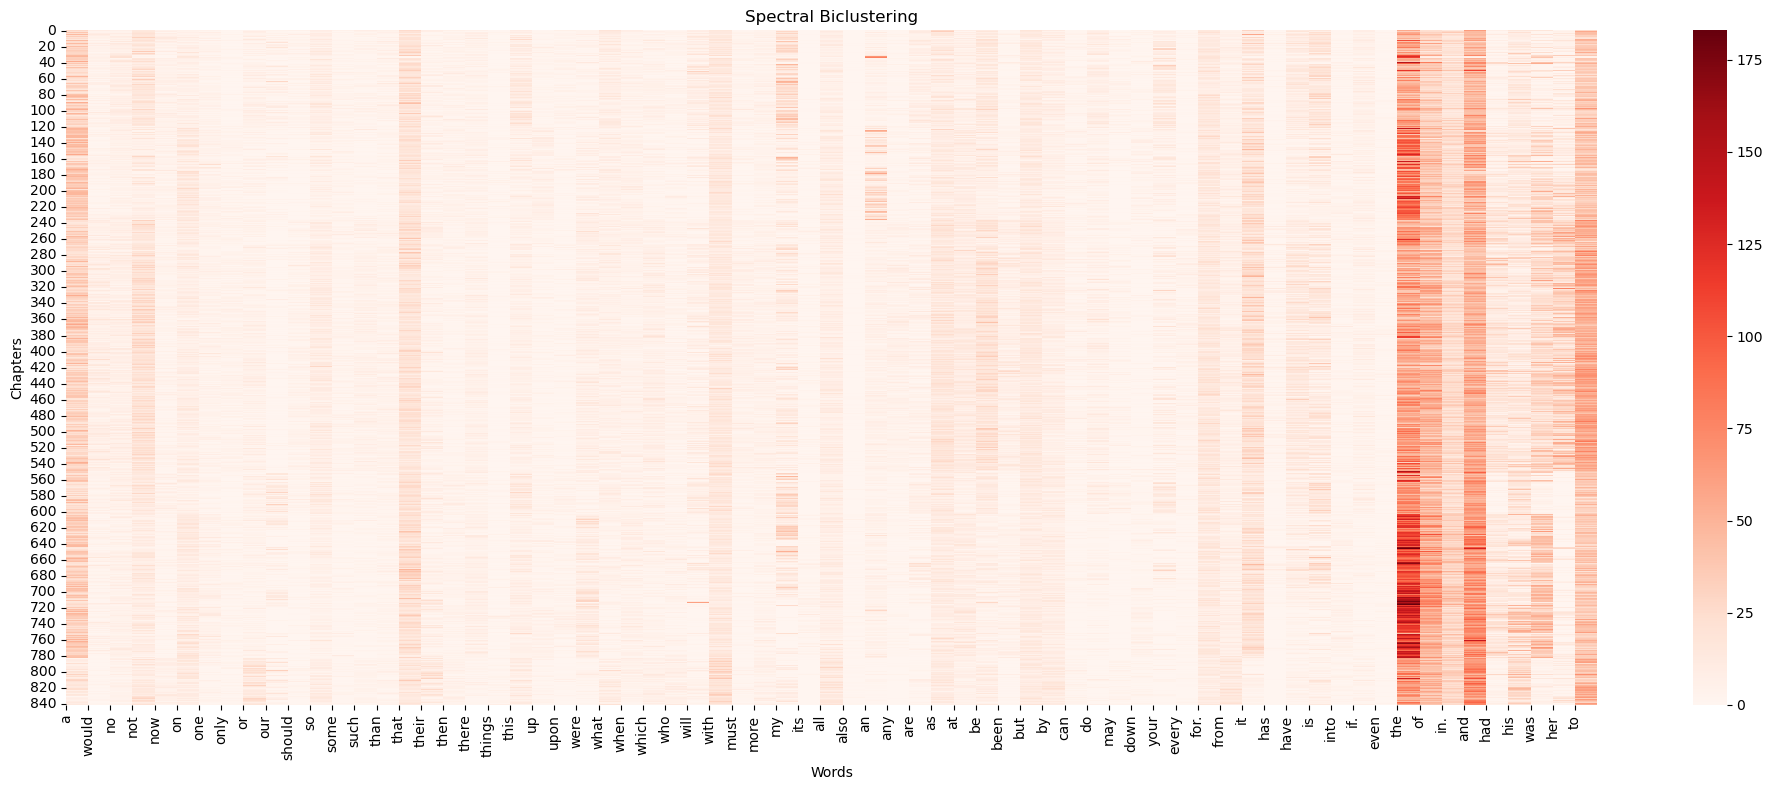

In [4]:
### Fit biclustering model
model = SpectralBiclustering(n_clusters=4, method='log', random_state=0)
model.fit(X)

### Reorder the data
row_order = np.argsort(model.row_labels_)
col_order = np.argsort(model.column_labels_)
fit_data = X.values[row_order][:, col_order]

### Get reordered word labels for x-axis
word_labels = X.columns[col_order]

### Visualization
plt.figure(figsize=(20, 8))  # wider figurea
sns.heatmap(fit_data, cmap="Reds", cbar=True)
plt.xticks(ticks=np.arange(len(word_labels)), labels=word_labels, rotation=90)
plt.title("Spectral Biclustering")
plt.xlabel("Words")
plt.ylabel("Chapters")
plt.tight_layout()
plt.savefig('Media/viz/03/single_plots/spectral_biclustering_viz')
plt.show()


Since words like "the", "and", "to", ... are used frequently across chapters on a global level there is not much insights to be deduced here.  We want to look for at words with specific chapters having bands.  This will help us to differentiate a word that is frequently used across a cluster of chapters indicating stylistic writing by the author!  This will help with classifying these chapters to their respective authors!!  There is a small problem that the common words are very dark so it is harder to see a contrast in scale so we will convert the scale to log scale to see a larger contrast among the less frequently used words.

### Log-Scale (Improve Visualization)

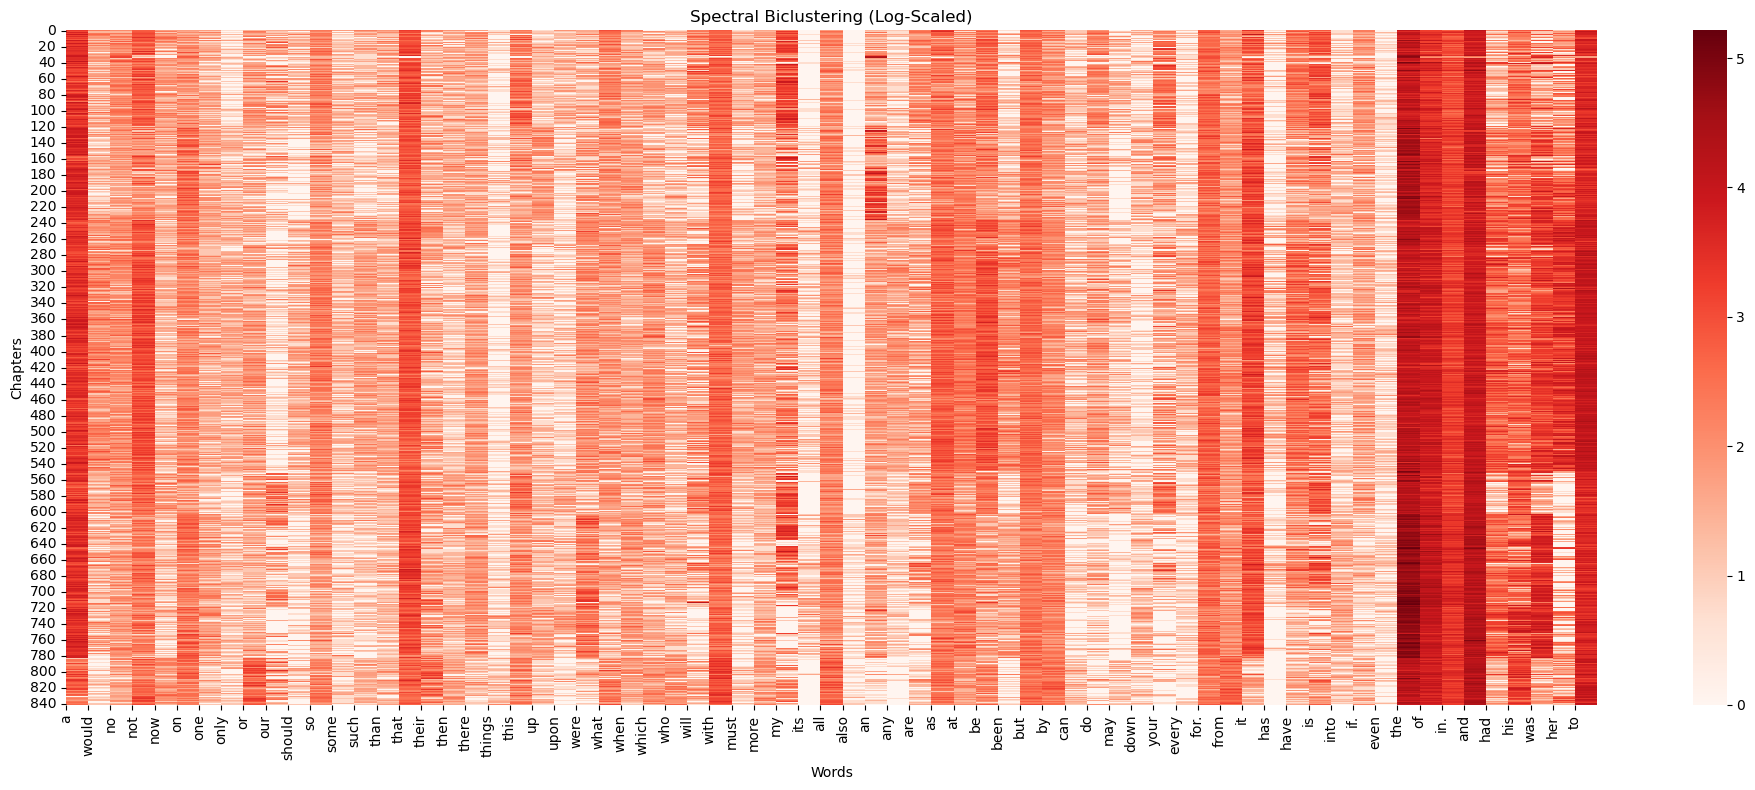

In [5]:
### Reorder the data
row_order = np.argsort(model.row_labels_)
col_order = np.argsort(model.column_labels_)
fit_data = X.values[row_order][:, col_order]

### Get reordered word labels for x-axis
word_labels = X.columns[col_order]

### Apply log scale to compress high-frequency words like "the"
log_data = np.log1p(fit_data)  # log(1 + x) to avoid log(0)

### Plot the heatmap
plt.figure(figsize=(20, 8))
sns.heatmap(log_data, cmap="Reds", cbar=True)

plt.xticks(ticks=np.arange(len(word_labels)), labels=word_labels, rotation=90)
plt.title("Spectral Biclustering (Log-Scaled)")
plt.xlabel("Words")
plt.ylabel("Chapters")
plt.tight_layout()
plt.savefig('Media/viz/03/single_plots/log_scale_spectral_biclustering_viz')
plt.show()

### Final Visualization

Plot side by side for visualization/comparison purposes.

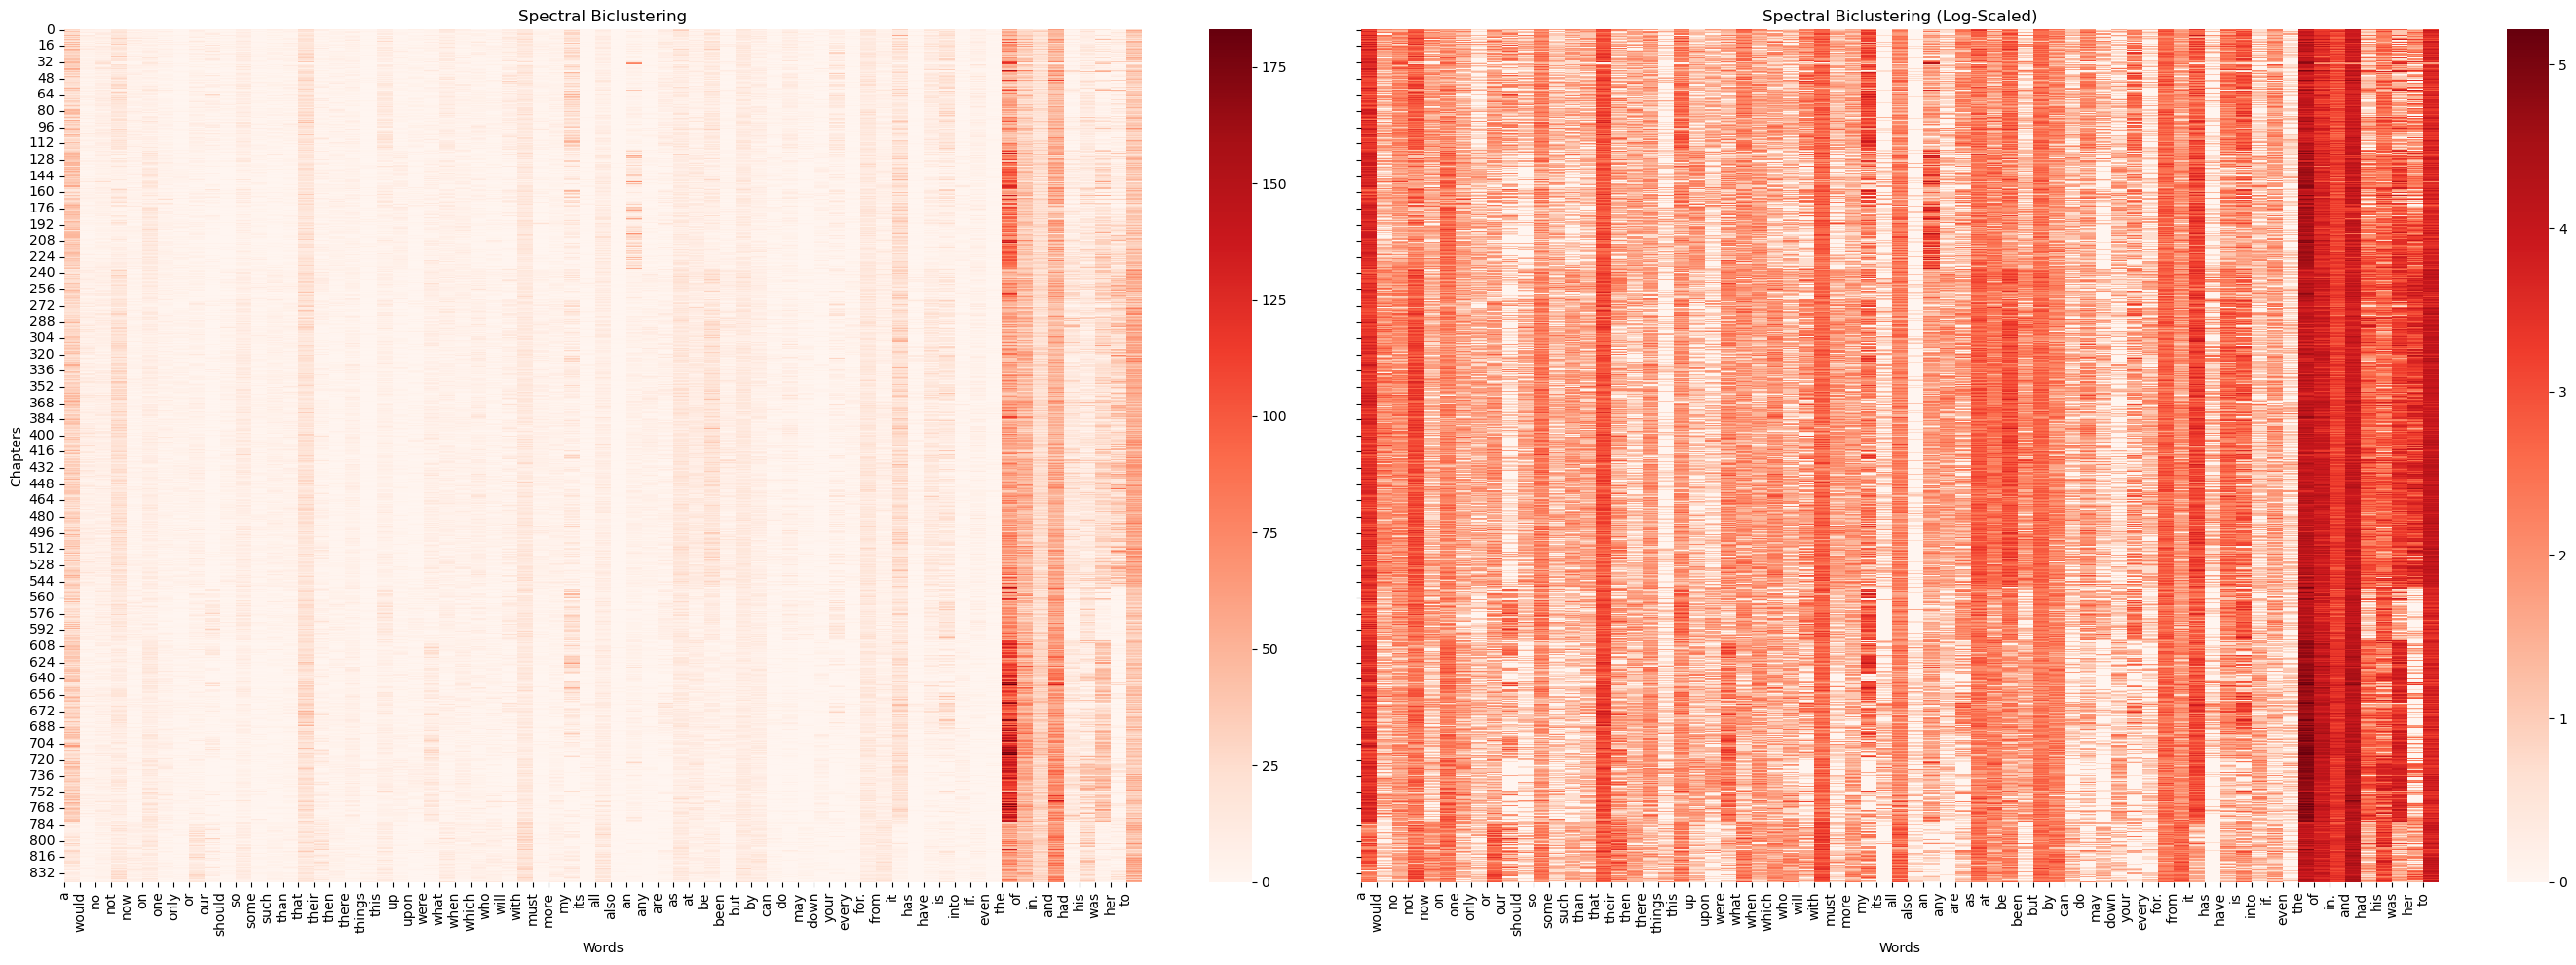

In [6]:
# Plot side-by-side heatmaps
fig, axes = plt.subplots(1, 2, figsize=(28, 10), sharey=True)

# Original
sns.heatmap(fit_data, cmap="Reds", ax=axes[0], cbar=True)
axes[0].set_xticks(np.arange(len(word_labels)))
axes[0].set_xticklabels(word_labels, rotation=90)
axes[0].set_title("Spectral Biclustering")
axes[0].set_xlabel("Words")
axes[0].set_ylabel("Chapters")

# Log-scaled
sns.heatmap(log_data, cmap="Reds", ax=axes[1], cbar=True)
axes[1].set_xticks(np.arange(len(word_labels)))
axes[1].set_xticklabels(word_labels, rotation=90)
axes[1].set_title("Spectral Biclustering (Log-Scaled)")
axes[1].set_xlabel("Words")
axes[1].set_ylabel("")

plt.tight_layout()
plt.savefig('Media/viz/03/03_spectral_biclustering_heatmaps')
plt.show()

## Hierarchial Biclustering

In [7]:
# Define top 4 method-metric combinations (all Euclidean)
combinations = [
    ('ward', 'euclidean'),
    ('average', 'euclidean'),
    ('complete', 'euclidean'),
    ('single', 'euclidean'),
]

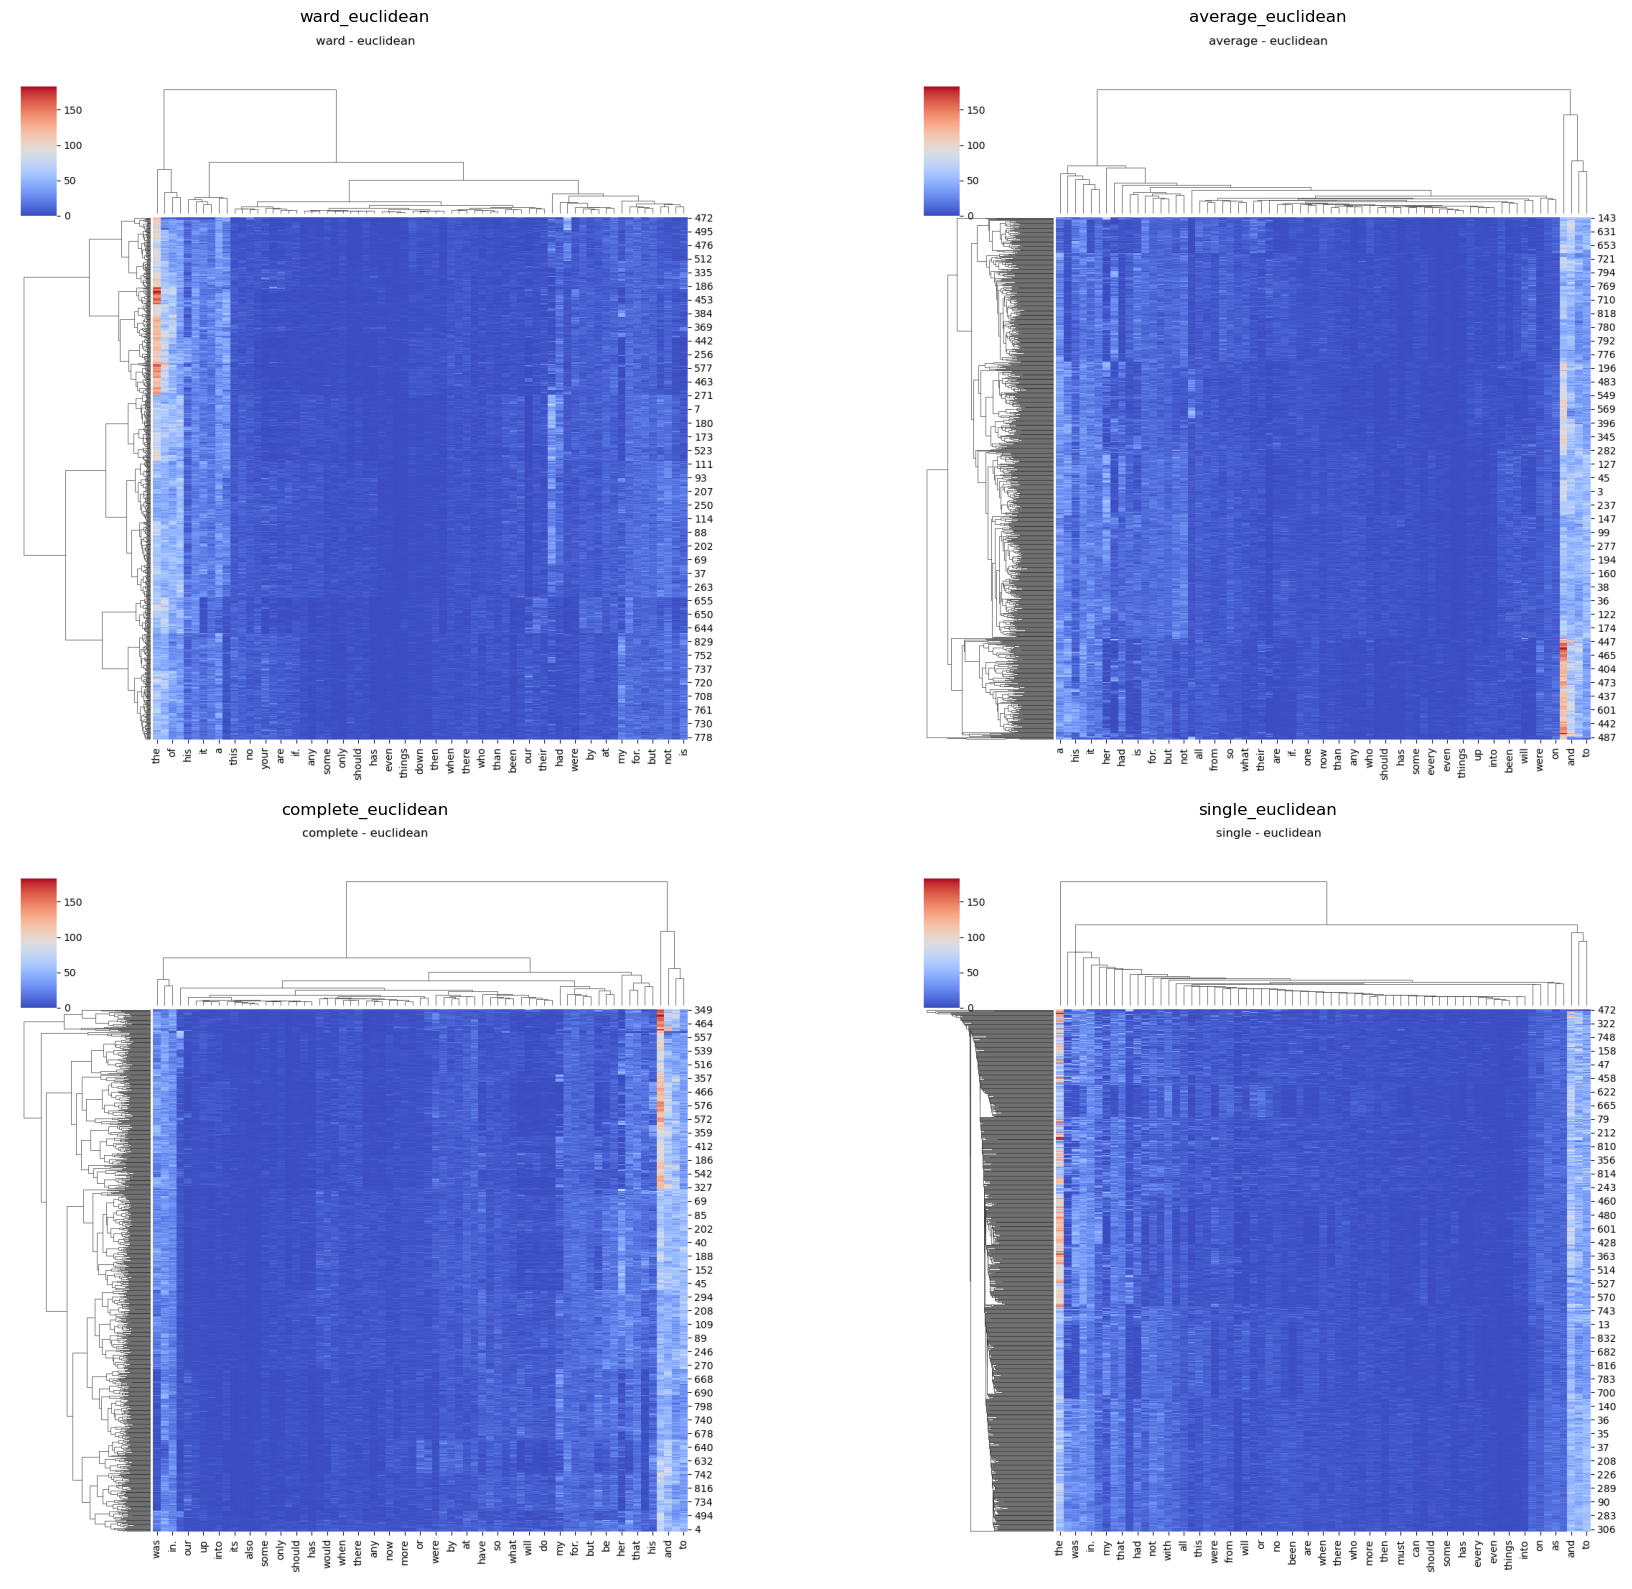

In [8]:
img_paths = []
for method, metric in combinations:
    g = sns.clustermap(X, method=method, metric=metric, cmap='coolwarm')
    g.fig.suptitle(f'{method} - {metric}', y=1.05)
    img_path = f'Media/viz/03/single_plots/clustermap_{method}_{metric}.png'
    g.savefig(img_path, bbox_inches='tight')
    plt.close(g.fig)
    img_paths.append(img_path)

fig, axes = plt.subplots(2, 2, figsize=(20, 16))
for ax, path in zip(axes.flatten(), img_paths):
    img = Image.open(path)
    ax.imshow(img)
    ax.set_title(path.split('/')[-1].replace('clustermap_', '').replace('.png', ''))
    ax.axis('off')

plt.tight_layout()
plt.savefig('Media/viz/03/03_hierarchial_biclustering_heatmaps')
plt.show()

This clustermap visualizes word frequency across chapters using hierarchical clustering on both rows (chapters) and columns (words). Chapters with similar word usage patterns are grouped together, as are words that tend to co-occur across the same sets of chapters. The dendrograms reveal hidden structure in the data, highlighting natural groupings based on stylistic similarity without any labels. This helps identify clusters of similar chapters and potentially stylistically meaningful groups of words.

However, we can see that the interpretation from these heatmaps is tricky so lets try and reduce the features with low variance patterns. So we will do some initial feature filtering, then perform the same heatmap visualizations!

In [9]:
X_filtered_dict = {'var_threshold':[], 'X_filtered_df':[]}
thresholds_list = [10, 25, 50, 75, 100, 150]
combinations = [('ward', 'euclidean')]
for alpha in thresholds_list: # Loop over variance filter threshold as alpha increase, more features are dropped!
    selector = VarianceThreshold(threshold=alpha)
    X_reduced = selector.fit_transform(X)
    selected_columns = X.columns[selector.get_support()] # Get the column names that passed this variance threshold
    X_filtered = pd.DataFrame(X_reduced, columns=selected_columns, index=X.index)
    X_filtered_dict['var_threshold'].append(alpha)
    X_filtered_dict['X_filtered_df'].append(X_filtered)

Plotting a grid across variance thresholds as follows.

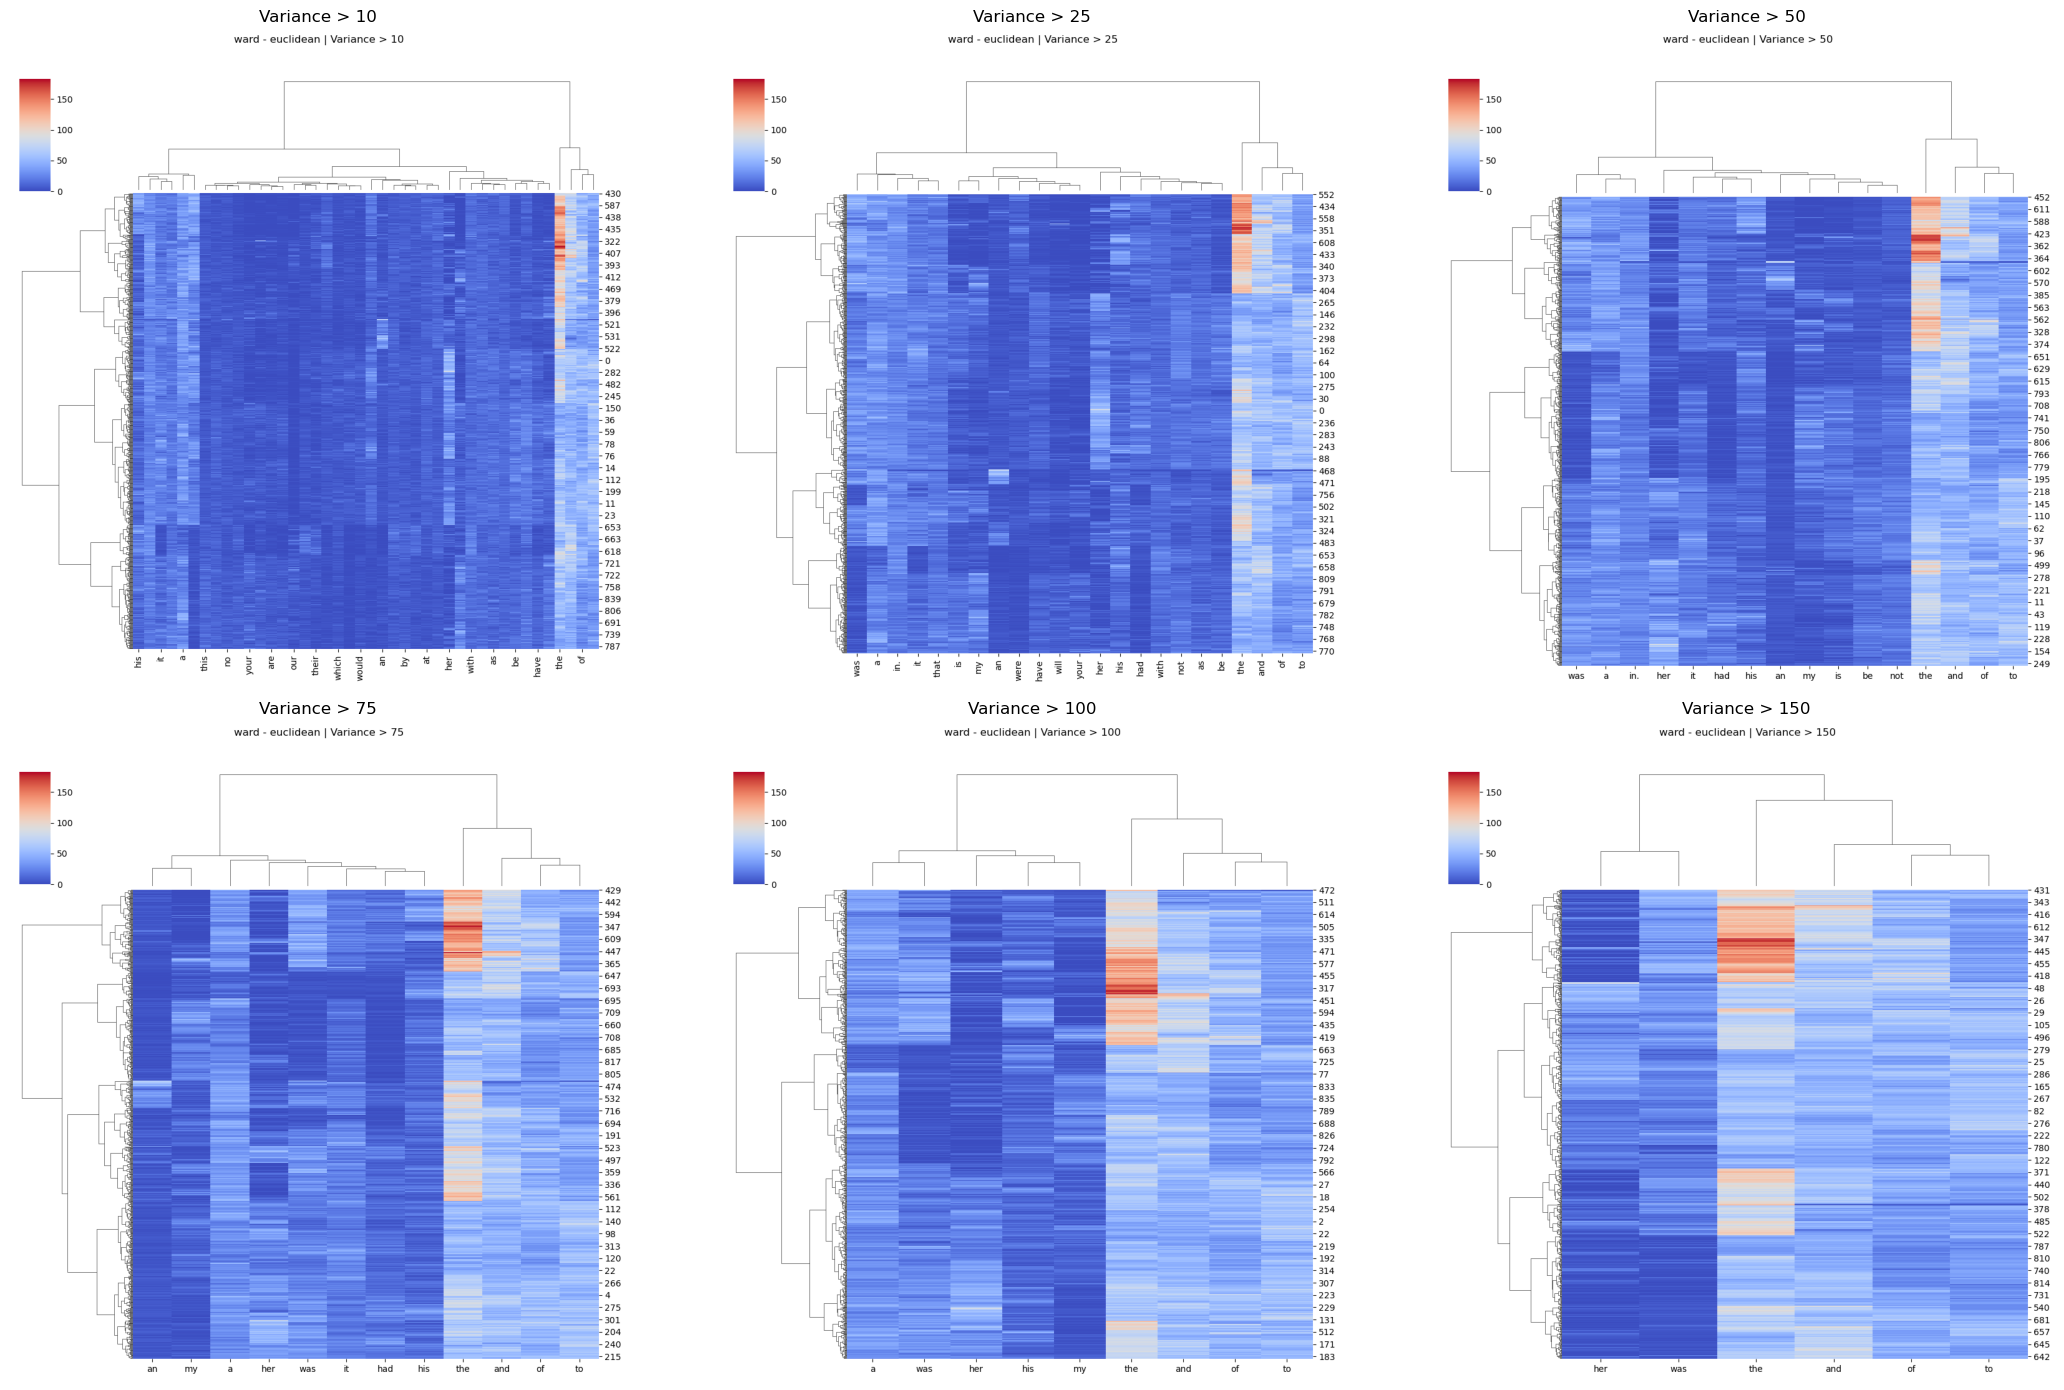

In [10]:
img_paths = []
for alpha in thresholds_list:
    selector = VarianceThreshold(threshold=alpha)
    try:
        X_reduced = selector.fit_transform(X)
        selected_columns = X.columns[selector.get_support()]
        if len(selected_columns) == 0:
            continue
        X_filtered = pd.DataFrame(X_reduced, columns=selected_columns, index=X.index)

        for method, metric in combinations:
            g = sns.clustermap(X_filtered, method=method, metric=metric, cmap='coolwarm')
            g.fig.suptitle(f'{method} - {metric} | Variance > {alpha}', y=1.05)
            img_path = f'Media/viz/03/single_plots/reduced_clustermap_{method}_{metric}_var{alpha}.png'
            g.savefig(img_path, bbox_inches='tight')
            plt.close(g.fig)
            img_paths.append((img_path, alpha))
    except ValueError:
        continue  # Skip thresholds that drop all features

n_cols = 3
n_rows = -(-len(img_paths) // n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(22, 7 * n_rows))

for ax, (path, alpha) in zip(axes.flatten(), img_paths):
    img = Image.open(path)
    ax.imshow(img)
    ax.set_title(f'Variance > {alpha}', fontsize=12)
    ax.axis('off')

plt.tight_layout()
plt.savefig('Media/viz/03/03_hierarchical_biclustering_variance_grid.png')
plt.show()

This feature selection helps to make the patterns between the stop words (features) and the chapters a lot more distinguishable by dropping the sparse features that experience little variance across chapters.  From this we can see bands that may indicate a shift in semantics across chapters!